# Conditional-GAN on CelebA Dataset

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/04_gan/03_cgan/cgan.ipynb), Lincense: Apache-2.0
- Dataset: [Kaggle](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)

In [1]:
import time
from collections import defaultdict
from IPython import display
from typing import Any
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils

import jax
import jax.numpy as jnp
from functools import partial

from flax import struct
import flax.linen as nn
from flax.training import train_state

import optax
from clu import metrics

## 0. Train Parameters

In [2]:
DATA_DIR = '../../data/CelebFaces/img_align_celeba/img_align_celeba/'
ATTR_DIR = '../../data/CelebFaces/list_attr_celeba.csv'
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
Z_DIM = 128
LR = 5e-5
EPOCHS = 10
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
CRITIC_STEPS = 2
GP_WEIGHT = 10.0

LABEL = 'Smiling'
CLASSES = 2

## 1. Prepare dataset

In [3]:
# Convert images to tensors normalize them
def preprocess(img):
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5
    # img = tf.cast(img, tf.float32) / 255.
    # img = (img - 0.5) / tf.sqrt(0.5)
    return img

# Get labels
def get_labels():
    data_attr = pd.read_csv(ATTR_DIR)
    labels = data_attr[LABEL].to_list()
    # labels = np.where(labels == 1, 1, 0)
    labels = [x if x == 1 else 0 for x in labels]
    return labels
    
# Load lego dataset from directory
def get_dataset():
    labels = get_labels()
    
    train_ds = utils.image_dataset_from_directory(
        directory=DATA_DIR,
        labels=labels,
        color_mode='rgb',
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=None,
        shuffle=True,
        seed=1024,
        interpolation='bilinear',
    ) 

    train_ds = train_ds.map(lambda img, label: (preprocess(img), tf.one_hot(label, CLASSES)))
    train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

    return train_ds

In [4]:
def display_imgs(imgs):
    plt.figure(figsize=(16, 3))
    for i in range(8):
        ax = plt.subplot(1, 8, i+1)
        img = (np.array(imgs[i]) * 127.5 + 127.5).astype(int)
        # img = np.array(imgs[i]) * np.sqrt(0.5) + 0.5
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# plot training records
def show_records(history):
    plt.figure(figsize=(16, 3))
    for i, key in enumerate(history):
        ax = plt.subplot(1, len(history), i+1)
        ax.plot(history[key])
        ax.set_title(key)
    plt.show()

Found 202599 files belonging to 2 classes.
(128, 64, 64, 3)


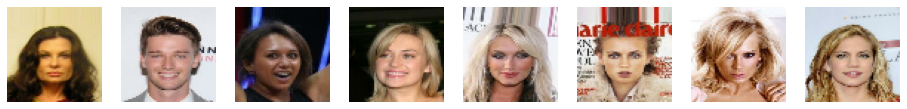

Labels:
 tf.Tensor(
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(8, 2), dtype=float32)


In [5]:
check_ds = get_dataset()
check_sample, labels = next(iter(check_ds))
print(check_sample.shape)
display_imgs(check_sample)
print("Labels:\n", labels[:8])

## 2. Building GAN

In [6]:
# Critic
class Critic(nn.Module):

    channel_list: tuple = (64, 128, 256, 512)
    
    @nn.compact
    def __call__(self, imgs, labels, train:bool):
        """
        imgs: (N, 64, 64, 3)
        labels: (N, 64, 64, 2)
        """
        x = jnp.concatenate([imgs, labels], axis=-1)
        
        # Convolutional layers
        for i, features in enumerate(self.channel_list):
            x = self.conv_block(x, features, i, train)

        # Output layers
        x = nn.Conv(features=1,
                    kernel_size=(4, 4), strides=1, 
                    padding='valid')(x)
        x = nn.sigmoid(x)
        x = x.reshape(-1, 1)
        return x

    # Downsampling convolution block
    def conv_block(self, x, out_features, use_dp, train:bool):
        x = nn.Conv(features=out_features,
                    kernel_size=(4, 4), strides=2,
                    padding='same')(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        if use_dp:
            x = nn.Dropout(rate=0.3, deterministic=not train)(x)
        return x

        
# The TrainStat classes and function for Critic
@struct.dataclass
class C_Metrics(metrics.Collection):
    c_wass_loss: metrics.Average.from_output('c_wass_loss')
    c_loss : metrics.Average.from_output('c_loss')
    c_gp : metrics.Average.from_output('c_gp')

    
# TrainState class for Critic
class CriticState(train_state.TrainState):
    key: jax.random.KeyArray
    metrics: C_Metrics

    
# funtion to create a critic state
def make_critic_state(module, params_key, dropout_key, 
                      learning_rate, train=False):

    # Initialize the model with initialization array
    params = module.init(params_key, jnp.ones((1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)), 
                         jnp.ones((1, IMAGE_SIZE, IMAGE_SIZE, CLASSES)), train=train)['params']
    # Create an optimizer
    tx = optax.adam(learning_rate=learning_rate, b1=ADAM_BETA_1, b2=ADAM_BETA_2)

    return CriticState.create(
            apply_fn=module.apply,
            params=params,
            key=dropout_key,
            tx=tx,
            metrics=C_Metrics.empty()
            )

net_C = Critic()
print(net_C.tabulate(jax.random.PRNGKey(0), 
                     jnp.ones((1, 64, 64, CHANNELS)), jnp.ones((1, 64, 64, CLASSES)), 
                     train=False, console_kwargs={'width': 100}))


                                           Critic Summary                                           
┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path      ┃ module  ┃ inputs               ┃ outputs              ┃ params                       ┃
┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           │ Critic  │ - float32[1,64,64,3] │ float32[1,1]         │                              │
│           │         │ - float32[1,64,64,2] │                      │                              │
│           │         │ - train: False       │                      │                              │
├───────────┼─────────┼──────────────────────┼──────────────────────┼──────────────────────────────┤
│ Conv_0    │ Conv    │ float32[1,64,64,5]   │ float32[1,32,32,64]  │ bias: float32[64]            │
│           │         │                      │                      │ kernel: float32[4,4,

In [7]:
class Generator(nn.Module):
    z_dim: int
    channel_list:tuple = (512, 256, 128, 64)

    @nn.compact
    def __call__(self, imgs, labels, train:bool):
        
        x = jnp.concatenate([imgs, labels], axis=-1)
        x = x.reshape(x.shape[0], 1, 1, x.shape[1])

        # Transpose convolution layers
        for i, features in enumerate(self.channel_list):
            strides = 2 if i else 1
            padding = 'SAME' if i else 'VALID'
            x = self.transconv_block(x, features, strides, padding, train)

        # Output layers
        x = nn.ConvTranspose(features=CHANNELS,
                             kernel_size=(4, 4), strides=(2, 2),
                             padding='SAME', use_bias=False)(x)
        x = nn.tanh(x)
        return x

        
    def transconv_block(self, x, out_features, strides, padding:str, train:bool):
        x = nn.ConvTranspose(features=out_features, 
                             kernel_size=(4, 4), strides=(strides, strides),
                             padding=padding, use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        return x


# The TrainStat classes and function for the Generator
@struct.dataclass
class G_Metrics(metrics.Collection):
    g_loss: metrics.Average.from_output('g_loss')

    
# TrainState class for the Generator
class GeneratorState(train_state.TrainState):
    batch_stats: Any # for batch normalization layers
    metrics: G_Metrics


# funtion to create a train state for modules
def make_generator_state(module, params_key,
                       learning_rate, train=False):

    # Initialize the model with initialization array
    variables = module.init(params_key, jnp.ones((1, Z_DIM)), jnp.ones((1, CLASSES)), train=train)
    params = variables['params']
    batch_stats = variables['batch_stats']

    # Create an optimizer
    tx = optax.adam(learning_rate=learning_rate, b1=ADAM_BETA_1, b2=ADAM_BETA_2)

    return GeneratorState.create(
            apply_fn=module.apply,
            params=params,
            batch_stats=batch_stats,
            tx=tx,
            metrics=G_Metrics.empty()
            )


netG = Generator(Z_DIM)
print(netG.tabulate(jax.random.PRNGKey(0), jnp.ones((1, Z_DIM)), jnp.ones((1, CLASSES)), train=False, console_kwargs={'width': 100}))


                                         Generator Summary                                          
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path           ┃ module        ┃ inputs        ┃ outputs        ┃ batch_stats   ┃ params         ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│                │ Generator     │ -             │ float32[1,64,… │               │                │
│                │               │ float32[1,12… │                │               │                │
│                │               │ -             │                │               │                │
│                │               │ float32[1,2]  │                │               │                │
│                │               │ - train:      │                │               │                │
│                │               │ False         │                │               │       

## 3. Loss functions

NOTE: the first argument of loss function in JAX should be the parameters that needed to be updated \
check here: https://github.com/google/flax/discussions/2420

In [8]:
# Loss function for generator
def g_loss_fn(g_state_params, c_state, g_state, labels, label_matrices, rng):
    latents = jax.random.normal(rng, shape=(BATCH_SIZE, Z_DIM))
    
    # generate fake images
    fake_imgs, g_variables = g_state.apply_fn(
                                {'params': g_state_params, 'batch_stats': g_state.batch_stats},
                                latents,
                                labels,
                                train=True,
                                mutable=['batch_stats'])
    
    # get discriminator's preds on fake images
    dropout_train_key = jax.random.fold_in(key=c_state.key, data=c_state.step)
    fake_preds = c_state.apply_fn(
                        {'params': c_state.params},
                        fake_imgs,
                        label_matrices,
                        train=True,
                        rngs={'dropout': dropout_train_key})

    
    g_loss = -fake_preds.mean()
    
    # Update metrics
    metric_updates = g_state.metrics.single_from_model_output(
                            g_loss = g_loss)
    metrics = g_state.metrics.merge(metric_updates)
    g_state = g_state.replace(metrics=metrics)
    
    return g_loss, (g_variables, g_state)


# get gradient penalty when training the critic
def gradient_penalty(real_imgs, fake_imgs, label_matrices, c_state, rng):
    @jax.grad
    def grad_fn(interpo_imgs):
        return c_state.apply_fn(
                        {'params': c_state.params},
                        interpo_imgs,
                        label_matrices,
                        train=True,
                        rngs={'dropout': dropout_key}).sum()
    
    dropout_train_key, rng = jax.random.split(rng, 2)
    # Get interpolated images
    alpha = jax.random.normal(rng, shape=(BATCH_SIZE, 1, 1, 1))
    interpo_imgs = (1 - alpha) * real_imgs + alpha * fake_imgs
    # compute gradient penalty
    grads = grad_fn(interpo_imgs)
    gd_norm = jnp.linalg.norm(grads.reshape(BATCH_SIZE, -1), axis=1)
    return jnp.mean((gd_norm - 1.0) ** 2)

    
# Loss function for discriminator
def c_loss_fn(c_state_params, c_state, g_state, real_imgs, labels, label_matrices, rng):
    
    # generate fake images
    latents = jax.random.normal(rng, shape=(BATCH_SIZE, Z_DIM))
    fake_imgs, g_variables = g_state.apply_fn(
                            {'params': g_state.params, 'batch_stats': g_state.batch_stats},
                            latents,
                            labels,
                            train=True,
                            mutable=['batch_stats'])

    # get discriminator's preds on real images
    dropout_train_key = jax.random.fold_in(key=c_state.key, data=c_state.step)
    real_preds = c_state.apply_fn(
                            {'params': c_state_params},
                            real_imgs,
                            label_matrices,
                            train=True,
                            rngs={'dropout': dropout_train_key})

    # get discriminator's preds on fake images
    dropout_train_key = jax.random.fold_in(key=c_state.key, data=c_state.step)
    fake_preds = c_state.apply_fn(
                            {'params': c_state_params},
                            fake_imgs,
                            label_matrices,
                            train=True,
                            rngs={'dropout': dropout_train_key})

    gp = gradient_penalty(real_imgs, fake_imgs, label_matrices, c_state, rng)
    
    # Compute losses
    real_loss = -real_preds.mean() # Gradient ascent for real loss
    fake_loss = fake_preds.mean() # Gradient descent for fake loss
    c_wass_loss = fake_loss + real_loss
    c_loss = c_wass_loss + GP_WEIGHT * gp


    # Update metrics
    metric_updates = c_state.metrics.single_from_model_output(
                                c_wass_loss = c_wass_loss,
                                c_loss = c_loss,
                                c_gp = gp)
    metrics = c_state.metrics.merge(metric_updates)
    c_state = c_state.replace(metrics=metrics)
    

    return c_loss, (g_variables, c_state)

## 4. Train step function

In [12]:
@jax.jit
def train_critic(rng, g_state, c_state, real_imgs, labels, label_matrices):
    rng, rng_c = jax.random.split(rng, num=2)
    # create gradient functions
    c_grad_fn = jax.value_and_grad(c_loss_fn, has_aux=True, allow_int=True)
    # update critic
    (c_loss, (g_variables, c_state)), c_grads = c_grad_fn(c_state.params, c_state, g_state, 
                                                          real_imgs, labels, label_matrices, 
                                                          rng_c)
    c_state = c_state.apply_gradients(grads=c_grads)
    return rng, c_state


@jax.jit
def train_generator(rng, g_state, c_state, labels, label_matrices):
    rng, rng_g = jax.random.split(rng, num=2)
    # create gradient function
    g_grad_fn = jax.value_and_grad(g_loss_fn, has_aux=True, allow_int=True)
    # update generator
    (g_loss, (g_variables, g_state)), g_grads = g_grad_fn(g_state.params, 
                                                          c_state, g_state,
                                                          labels, label_matrices, rng_g)
    g_state = g_state.apply_gradients(grads=g_grads)
    g_state = g_state.replace(batch_stats=g_variables['batch_stats'])
    return rng, g_state

## 5. Load datasets and create `train_stat`s

In [13]:
train_ds = get_dataset()
train_iter = iter(train_ds.as_numpy_iterator())
num_batch = len(train_ds)
print("Total num. of batches: ", num_batch)

rng = jax.random.PRNGKey(0)
c_param_key, g_param_key, dropout_key, rng = jax.random.split(key=rng, num=4)

# create networks
g_net = Generator(Z_DIM)
c_net = Critic()

# initialize networks train stats
g_state = make_generator_state(g_net, g_param_key, LR)
c_state = make_critic_state(c_net, c_param_key, dropout_key, LR)

Found 202599 files belonging to 2 classes.
Total num. of batches:  1582


## 6. Training

Epoch: 1	epoch time 1.46 min
	 c_wass_loss: -0.4307 | c_loss: 7.3744 | c_gp: 0.7805 | g_loss: -0.2027 | 


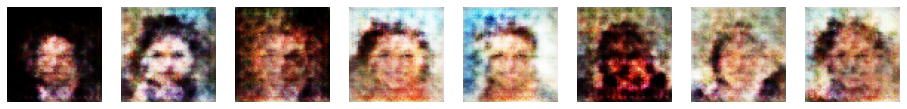

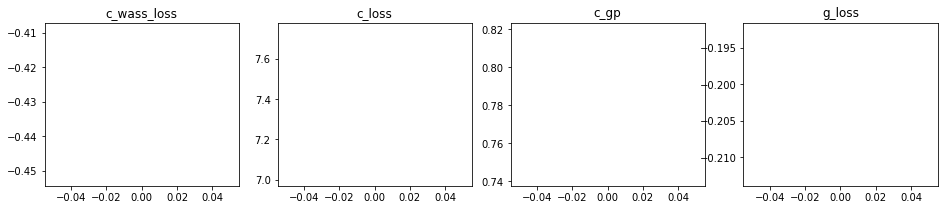

  0%|          | 0/1582 [00:00<?, ?it/s]

In [ ]:
prev_time = time.time()
history = defaultdict(list)

for epoch in range(EPOCHS):
    for i in tqdm(range(num_batch)):
        
        for _ in range(CRITIC_STEPS):    
            
            try:
                real_imgs, labels = next(train_iter)
            except StopIteration:
                train_iter = iter(train_ds.as_numpy_iterator())
                real_imgs, labels = next(train_iter)

            # Turn label into image matrix form: (N, 2) -> (N, 64, 64, 2)
            assert len(labels.shape) == 2, "Check label shape"
            label_matrices = labels[:, None, None, :]
            label_matrices = np.tile(label_matrices, (1, 64, 64, 1))
            assert len(label_matrices.shape) == 4, "Check label matrics shape"
            
            rng, c_state = train_critic(rng, g_state, c_state, real_imgs, labels, label_matrices)
            
        rng, g_state = train_generator(rng, g_state, c_state, labels, label_matrices)  

    
    for metric, value in c_state.metrics.compute().items():
        history[metric].append(value)
    c_state = c_state.replace(metrics=c_state.metrics.empty())
        
    for metric, value in g_state.metrics.compute().items():
        history[metric].append(value)
    g_state = g_state.replace(metrics=g_state.metrics.empty())


    # Generate fake images for checking purpose
    latents = jax.random.normal(rng, shape=(BATCH_SIZE, Z_DIM))
    fake_imgs = g_state.apply_fn({'params': g_state.params, 'batch_stats': g_state.batch_stats},
                                 latents, 
                                 labels,
                                 train=False)

    curr_time = time.time()
    # log out train stats
    display.clear_output(wait=True)
    print('Epoch: {}\tepoch time {:.2f} min'.format(epoch + 1, (curr_time - prev_time) / 60))
    metrics = [f'{key}: {value[-1]:.4f} | ' for key, value in history.items()]
    print('\t', ''.join(metrics))
    display_imgs(fake_imgs)
    show_records(history)
    prev_time = curr_time

## 7. Generate new images

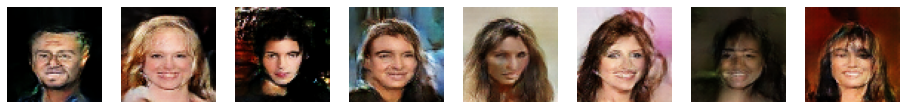

In [16]:
rng, key = jax.random.split(rng, 2)
latents = jax.random.normal(rng, shape=(BATCH_SIZE, Z_DIM))
fake_imgs = g_state.apply_fn({'params': g_state.params, 'batch_stats': g_state.batch_stats},
                             latents, train=False)
display_imgs(fake_imgs)